# Snake

This projet was developed by Pietro Girotto (ID 2088245).

As this notebook serves the purpose of showcasing the code used to solve the problem, it is not throughly commented. For a more detailed explanation of the code, please refer to the ```Report.pdf``` file.

## Setting up the environment
We will need a couple of libraries to run this project. ```trange``` can be easily avoided by replacing it with ```range``` in the code.

In [ ]:
!pip3 install -q numpy tqdm matplotlib tensorflow

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from environments_fully_observable import OriginalSnakeEnvironment
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from agents import BaselineAgent, RandomAgent, DQNAgent, HybridDQNAgent

# Fix random seeds for reproducibility
tf.random.set_seed(0) 
random.seed(0)
np.random.seed(0)

2024-08-26 17:13:55.071549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 17:13:55.137795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 17:13:55.147906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 17:13:55.246667: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 17:13:57.455527: W tensorflow/compiler/tf2

In [8]:
def plot_board(boards, how_many=5):
    """
    Plot the game boards. Visualizing them in a grid.
    Parameters:
    - boards (list): A list of game boards to be plotted. Numpy arrays of shape (width, height) or (batch, width, height).
    - how_many (int): The number of boards to be plotted. Default is 5.
    Returns:
    None
    """
    # code implementation...
    num_boards = min(len(boards), how_many)
    
    # If only one board is passed, axs should not be an array
    if num_boards == 1:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.imshow(boards[0], origin="lower")
    else:
        fig, axs = plt.subplots(1, num_boards, figsize=(10, 3))
        for ax, board in zip(axs, boards[:num_boards]):
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            ax.imshow(board, origin="lower")

    plt.show()

## Training the agents

Training was done on a 1000 boards x 1000 steps randomly generated dataset.

In [3]:
# Training hyperparameters
MOVES_PER_GAME = 1000
NUM_BOARDS = 1000
BOARD_SIZE = 7

In [15]:
tf.keras.utils.disable_interactive_logging()

rnd_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
base_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
dqn_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
hybrid_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)

rnd_agent = RandomAgent()
baseline_agent = BaselineAgent()
dqn_agent = DQNAgent(dqn_env.boards)
hybrid_agent = HybridDQNAgent(hybrid_env.boards)

rnd_rewards = []
baseline_rewards = []
dqn_rewards = []
hybrid_rewards = []

for _ in trange(MOVES_PER_GAME):
    # Get actions from the agents
    rnd_actions = rnd_agent.get_actions(rnd_env.boards)
    base_actions = baseline_agent.get_actions(base_env.boards)
    dqn_actions = dqn_agent.get_actions(dqn_env.boards)
    hybrid_actions = hybrid_agent.get_actions(hybrid_env.boards)

    dqn_prev_boards = dqn_env.boards.copy()
    hybrid_prev_boards = hybrid_env.boards.copy()
    
    # Perform the actions and get the rewards from the environment
    rnd_reward = rnd_env.move(rnd_actions)
    baseline_reward = base_env.move(base_actions)
    dqn_reward = dqn_env.move(dqn_actions)
    hybrid_reward = hybrid_env.move(hybrid_actions)

    # Learn from it
    dqn_agent.learn(dqn_prev_boards, dqn_actions, dqn_reward, dqn_env.boards)
    hybrid_agent.learn(hybrid_prev_boards, hybrid_actions, hybrid_reward, hybrid_env.boards)

    
    # Store the rewards for each move
    rnd_rewards.append(np.mean(rnd_reward))
    baseline_rewards.append(np.mean(baseline_reward))
    dqn_rewards.append(np.mean(dqn_reward))
    hybrid_rewards.append(np.mean(hybrid_reward))

100%|██████████| 1000/1000 [52:19<00:00,  3.14s/it]


## Plotting the results

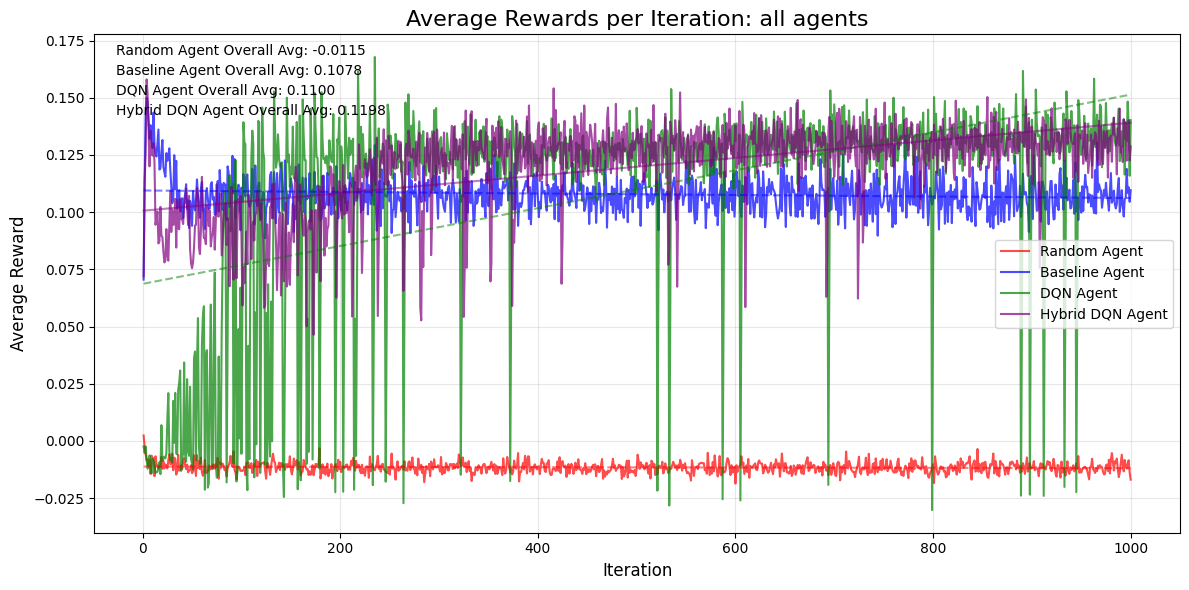

In [25]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, MOVES_PER_GAME + 1), rnd_rewards, label='Random Agent', color='red', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), baseline_rewards, label='Baseline Agent', color='blue', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), dqn_rewards, label='DQN Agent', color='green', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), hybrid_rewards, label='Hybrid DQN Agent', color='purple', alpha=0.7)

# Add a trend line for each agent
z_rnd = np.polyfit(range(1, MOVES_PER_GAME + 1), rnd_rewards, 1)
p_rnd = np.poly1d(z_rnd)
plt.plot(range(1, MOVES_PER_GAME + 1), p_rnd(range(1, MOVES_PER_GAME + 1)), "r--", alpha=0.5)

z_base = np.polyfit(range(1, MOVES_PER_GAME + 1), baseline_rewards, 1)
p_base = np.poly1d(z_base)
plt.plot(range(1, MOVES_PER_GAME + 1), p_base(range(1, MOVES_PER_GAME + 1)), "b--", alpha=0.5)

z_dqn = np.polyfit(range(1, MOVES_PER_GAME + 1), dqn_rewards, 1)
p_dqn = np.poly1d(z_dqn)
plt.plot(range(1, MOVES_PER_GAME + 1), p_dqn(range(1, MOVES_PER_GAME + 1)), "g--", alpha=0.5)

z_hybrid = np.polyfit(range(1, MOVES_PER_GAME + 1), hybrid_rewards, 1)
p_hybrid = np.poly1d(z_hybrid)
plt.plot(range(1, MOVES_PER_GAME + 1), p_hybrid(range(1, MOVES_PER_GAME + 1)), "purple", alpha=0.5)

# Customize the plot
plt.title('Average Rewards per Iteration: all agents', fontsize=16)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add text with overall average rewards
plt.text(0.02, 0.98, f"Random Agent Overall Avg: {np.mean(rnd_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.94, f"Baseline Agent Overall Avg: {np.mean(baseline_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.90, f"DQN Agent Overall Avg: {np.mean(dqn_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.86, f"Hybrid DQN Agent Overall Avg: {np.mean(hybrid_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

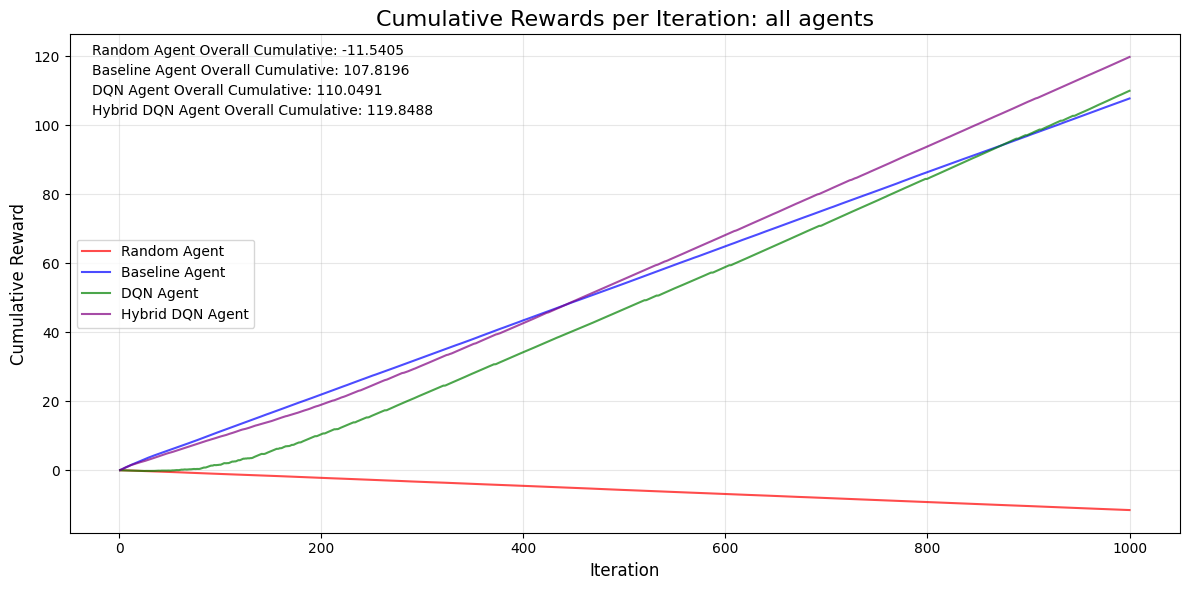

In [26]:
# Now plot the cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(rnd_rewards), label='Random Agent', color='red', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(baseline_rewards), label='Baseline Agent', color='blue', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(dqn_rewards), label='DQN Agent', color='green', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(hybrid_rewards), label='Hybrid DQN Agent', color='purple', alpha=0.7)

# Customize the plot
plt.title('Cumulative Rewards per Iteration: all agents', fontsize=16)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=12)
plt.legend(fontsize=10, loc="center left")
plt.grid(True, alpha=0.3)

# Add text with overall cumulative rewards
plt.text(0.02, 0.98, f"Random Agent Overall Cumulative: {np.sum(rnd_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.94, f"Baseline Agent Overall Cumulative: {np.sum(baseline_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.90, f"DQN Agent Overall Cumulative: {np.sum(dqn_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.86, f"Hybrid DQN Agent Overall Cumulative: {np.sum(hybrid_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

Clearly the hybrid agent outperforms all of the other agents during training. The random agent is the worst as expected, but the DQL agent takes a long time to learn, beating the rule-based agent only around the 900th episode.

Now saving the trained model to disk.

In [27]:
hybrid_model = hybrid_agent.model
hybrid_model.save_weights("hybrid_model.weights.h5")

## Evaluation

This section is dedicated to evaluating the performance of the trained agents by keeping track of the number of times the baseline and the hybrid agents ate themselves, hit the wall, and the number of apples eaten.

In [4]:
# Disable interactive logging
tf.keras.utils.disable_interactive_logging()

# Initialize environments and agents
base_env = OriginalSnakeEnvironment(1000, BOARD_SIZE)
hybrid_env = OriginalSnakeEnvironment(1000, BOARD_SIZE)

hybrid_agent_test = HybridDQNAgent(hybrid_env.boards)
hybrid_agent_test.load_model_weights("hybrid_model.weights.h5")
baseline_agent_test = BaselineAgent()

# Initialize variables for tracking fruits eaten
hybrid_fruits_list = []
baseline_fruits_list = []

hybrid_wall_hits = []
baseline_wall_hits = []

hybrid_ate_himself_list = []
baseline_ate_himself_list = []

hybrid_fruits = 0
baseline_fruits = 0

hybrid_wall = 0
baseline_wall = 0

hybrid_ate_himself = 0
baseline_ate_himself = 0

# Perform 1000 iterations
for step in trange(1000):
    # Get actions from the agents
    hybrid_actions = hybrid_agent_test.get_actions(hybrid_env.boards)
    baseline_actions = baseline_agent_test.get_actions(base_env.boards)
    
    # Perform the actions and get the rewards from the environment
    hybrid_reward = hybrid_env.move(hybrid_actions)
    baseline_reward = base_env.move(baseline_actions)
    
    # The fruit reward is 0.5, count the number of fruits eaten
    hybrid_fruits += np.sum(hybrid_reward == 0.5)
    baseline_fruits += np.sum(baseline_reward == 0.5)

    # The wall hit reward is -0.1, count the number of wall hits
    hybrid_wall += np.sum(hybrid_reward == -0.1)
    baseline_wall += np.sum(baseline_reward == -0.1)

    # The ate himself reward is -0.2, count the number of times the snake ate himself
    hybrid_ate_himself += np.sum(hybrid_reward == -0.2)
    baseline_ate_himself += np.sum(baseline_reward == -0.2)
    
    # Every 10 steps, save the current number of fruits eaten
    if (step + 1) % 10 == 0:
        hybrid_fruits_list.append(hybrid_fruits)
        baseline_fruits_list.append(baseline_fruits)

        hybrid_wall_hits.append(hybrid_wall)
        baseline_wall_hits.append(baseline_wall)

        hybrid_ate_himself_list.append(hybrid_ate_himself)
        baseline_ate_himself_list.append(baseline_ate_himself)

/home/gp-1108/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/gp-1108/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


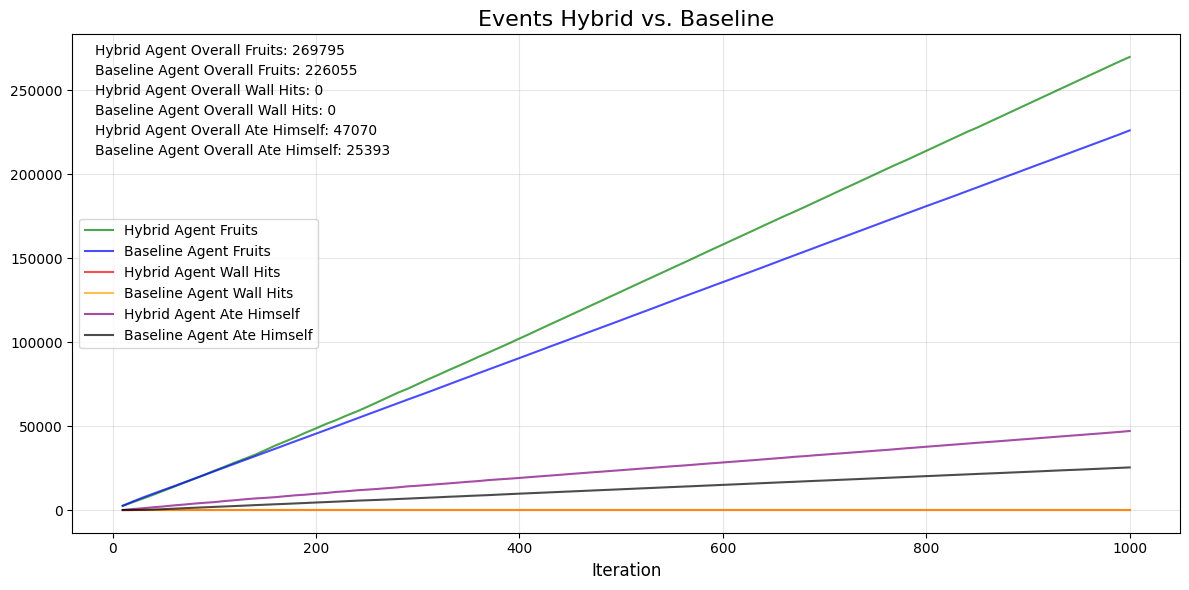

In [33]:
# Plot the cumulative fruits eaten
plt.figure(figsize=(12, 6))
plt.plot(range(10, 1001, 10), hybrid_fruits_list, label='Hybrid Agent Fruits', color='green', alpha=0.7)
plt.plot(range(10, 1001, 10), baseline_fruits_list, label='Baseline Agent Fruits', color='blue', alpha=0.7)
plt.plot(range(10, 1001, 10), hybrid_wall_hits, label='Hybrid Agent Wall Hits', color='red', alpha=0.7)
plt.plot(range(10, 1001, 10), baseline_wall_hits, label='Baseline Agent Wall Hits', color='orange', alpha=0.7)
plt.plot(range(10, 1001, 10), hybrid_ate_himself_list, label='Hybrid Agent Ate Himself', color='purple', alpha=0.7)
plt.plot(range(10, 1001, 10), baseline_ate_himself_list, label='Baseline Agent Ate Himself', color='black', alpha=0.7)

# Customize the plot
plt.title('Events Hybrid vs. Baseline', fontsize=16)
plt.xlabel('Iteration', fontsize=12)
plt.legend(fontsize=10, loc="center left")
plt.grid(True, alpha=0.3)

# Add text with overall cumulative fruits eaten
plt.text(0.02, 0.98, f"Hybrid Agent Overall Fruits: {hybrid_fruits}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.94, f"Baseline Agent Overall Fruits: {baseline_fruits}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.90, f"Hybrid Agent Overall Wall Hits: {hybrid_wall}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.86, f"Baseline Agent Overall Wall Hits: {baseline_wall}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.82, f"Hybrid Agent Overall Ate Himself: {hybrid_ate_himself}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.78, f"Baseline Agent Overall Ate Himself: {baseline_ate_himself}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

It is clear how there might be a correlation between the number of apples eaten and the number of times the agent ate itself. This might be due to the fact that the agent may eat itself to allow for a better path to the apple and faster collection overall.